# Explore Scenario Discovery

In [2]:
# !pip install altair
# !pip install ema_workbench

##  IMPORT PACKAGES
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging

import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sys
from typing import *

# add the current directoy to the search path and load from here
dir_py = os.path.join(os.getcwd(), "python")
if dir_py not in sys.path:
    sys.path.append(dir_py)


##  Computational experiments are often used to generate large datasets, which can be condensed and used for scenario discovery
- Consider the following example data, derived from an experiment to assess the costs and benefits of decarboniation in Latin America
    - https://publications.iadb.org/en/benefits-and-costs-reaching-net-zero-emissions-latin-america-and-caribbean
- Three different experiments are summarized here:
    - `design_id = 0`: Emissions with No Actions taken (includes costs and benefits field, but not valid in this design)
    - `design_id = 1`: Emissions with implementation levels for groups of levers ranging from 25% to 100% (random)
    - `design_id = 2`: Emissions with implementation levels for groups of levers ranging from 25% to 100% (with 20% chance that a given variable will face 100% implementation or 20% that it will face 25% implementation)
- We will examine `design_id = 1`:
    - **Goal(s) of Experiment**: 
        - (+) Identify robust levers that drive reductions in emissions
        - (-) Identify levers that that lead to lower emissions, but with low net benefits
    

In [91]:
# read data
dir_ref = os.path.join(os.getcwd(), "ref")
df_exploratory_data = pd.read_csv(os.path.join(dir_ref, "pt_clean.csv"))
#df_exploratory_data = pd.read_csv("/Users/jsyme/Downloads/pt.csv")

##  SET SOME FIELDS

field_cb = "cb_valueX"
field_emission = "emission_co2e_TOTAL_50"


##  FILTER ON DESIGN 

df_exploratory_data = (
    df_exploratory_data[
        df_exploratory_data["design_id"].isin([1])
    ]
    .reset_index(drop = True)
)

# Let's look at some of the metrics (M) of interest
- Aggregate emissions in Latin America, MT CO2e
- Net benefits, USD

(array([  6.,  28.,  46.,  77., 145., 203., 224., 150.,  81.,  25.]),
 array([-2017.        , -1618.24690088, -1219.49380175,  -820.74070263,
         -421.98760351,   -23.23450438,   375.51859474,   774.27169386,
         1173.02479299,  1571.77789211,  1970.53099123]),
 <BarContainer object of 10 artists>)

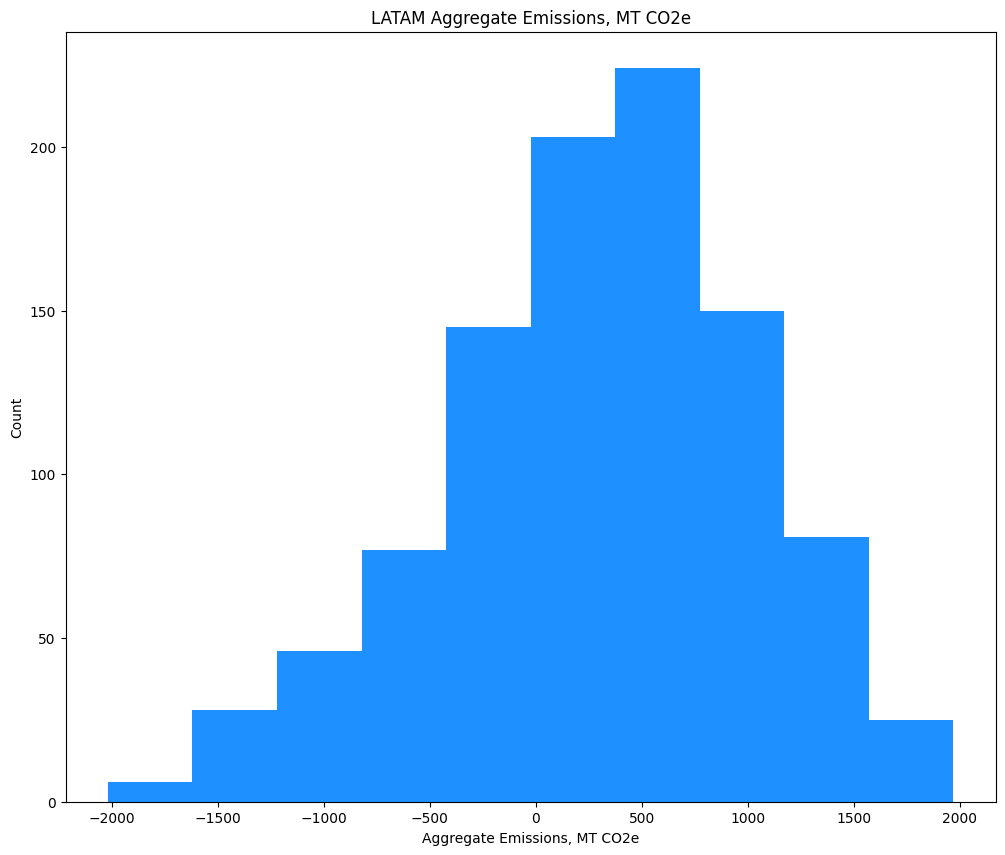

In [92]:
fig, ax = plt.subplots(figsize = (12, 10))

ax.set_title(f"LATAM Aggregate Emissions, MT CO2e")
ax.set_xlabel(f"Aggregate Emissions, MT CO2e")
ax.set_ylabel(f"Count")

ax.hist(
    df_exploratory_data[field_emission].to_numpy(),
    color = "dodgerblue" # Go Dodgers
)

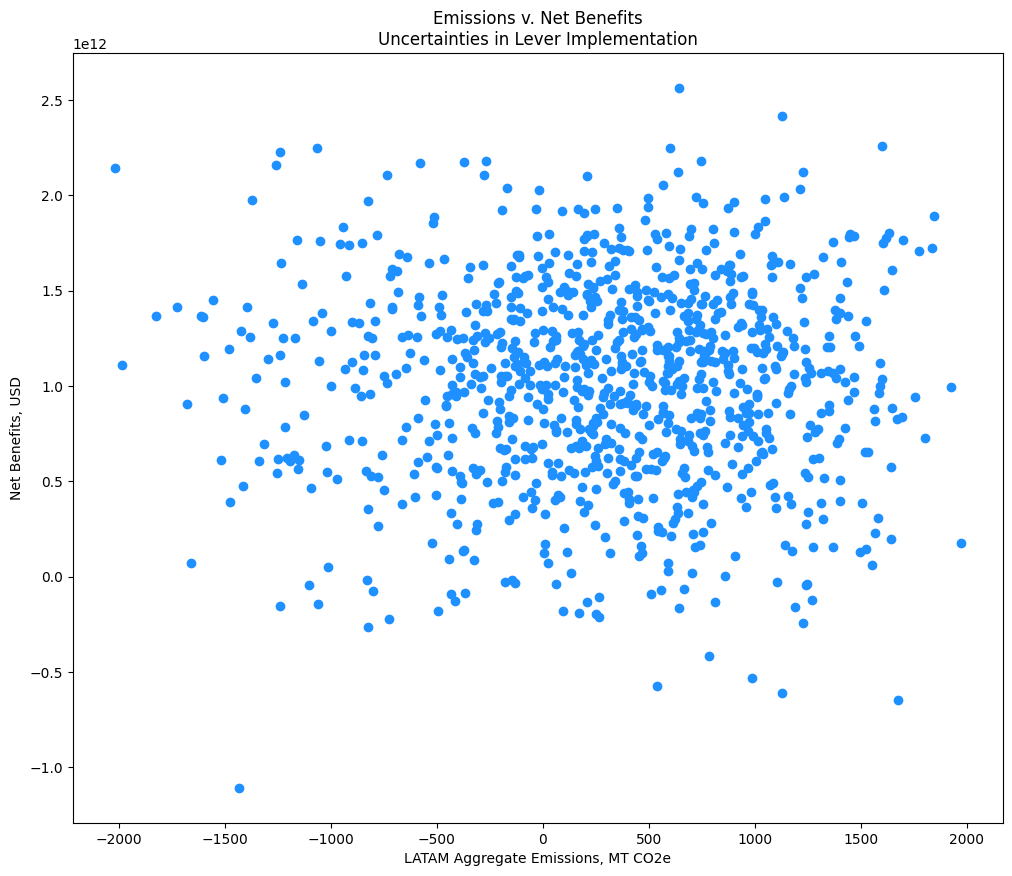

In [93]:
fig, ax = plt.subplots(figsize = (12, 10))

ax.set_title(f"Emissions v. Net Benefits\nUncertainties in Lever Implementation")
ax.set_xlabel(f"LATAM Aggregate Emissions, MT CO2e")
ax.set_ylabel(f"Net Benefits, USD")

ax.scatter(
    df_exploratory_data[field_emission].to_numpy(),
    df_exploratory_data[field_cb].to_numpy(),
    color = "dodgerblue" # Go Dodgers
)

##  Define some cases of interest
- In a vulnerability assessment, cases of interest are those where modeling indicates that the system reaches vulnerable conditions
- There may be different types of vulnerabilities worth assessing
- Let's start with one that is based exclusively on aggregate emissions

In [106]:
field_vuln_0 = "v0"

# let's define a vulnerability condition; an obvious one is if the actions fail to meet net zero
vec_vuln_0 = [
    int(row[field_emission] < 0) for i, row in df_exploratory_data.iterrows()
]

df_exploratory_data[field_vuln_0] = vec_vuln_0

# fraction of cases that are vulnerable
frac_vuln = sum(vec_vuln_0)/df_exploratory_data.shape[0]
perc_vuln = np.round(100*frac_vuln, decimals = 2)
print(f"Approximately {perc_vuln}% cases are vulnerable")

Approximately 31.57% cases are vulnerable


# Call PRIM, or **P**atient **R**ule **I**nduction **M**ethod
- PRIM is a bump-hunting algorithm that iteratively adds dimensional bounds to create boxes that best capture cases of interest
- Each box represents a bound on some number of dimensions $m \leq n$ for the input space of $n$-dimensional vectors $x \in X$, $X \subset \mathbb{R}^n$ 
- The trajectory of boxes identified by PRIM create a tradeoff between **Coverage** and **Density**
    - **Coverage**: fraction of all cases of interest explained within the box, or
        
        $C(B) = \frac{|B|}{|X_1|}$,
            
        where $X_1 \subset X$ is the set of all inputs of interest ($X \subset \mathbb{R}^n$) and $B \in \mathbb{R}^m$ is an $m$-dimensional box, $m \leq n$
        
    - **Density**: fraction of all cases in the box that are of interest, or 
    
        $D(B) = \frac{|x_1 \bigcap B|}{|B|}$
            
- Other algorithms can be used to perform the same actions, such as Random Forest or CART


In [107]:
# set some fields
fields_u = [x for x in df_exploratory_data.columns if x.startswith("u")]
fields_x = [x for x in df_exploratory_data.columns if x.startswith("X")]

# get input conditions to search over (x) and vector of outcomes (y)
arr_x = df_exploratory_data[fields_x]
vec_y = df_exploratory_data[field_vuln_0].to_numpy()

prim_alg = prim.Prim(
    arr_x, 
    vec_y, 
    peel_alpha = 0.1, # parameter governing # of boxes; higher number -> fewer boxes
    threshold = 0.5, # threshold 
    threshold_type = 1, # 1 -> ABOVE, 2 -> BELOW 
)
boxes = prim_alg.find_box()

##  After running, it's useful to inspect what is known as the *Peeling Tracjectory*, which shows the tradeoff between coverage and density
- Genereally speaking, a well-performing dataset will show a concave Pareto frontier:
    - Higher coverage is associated with a lower number of dimensional restrictions
    - Higher density is associated with a higher number of dimensional restrictions
    - Why? How do you choose a box?

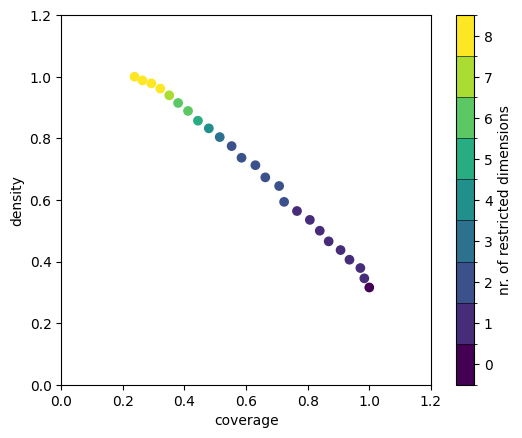

In [108]:
boxes.show_tradeoff()
plt.show()

# T

In [109]:
boxes.inspect_tradeoff()

alt.VConcatChart(...)

# What are the input factors, "X##"?
- describe here
- add table

In [110]:
os.listdir(dir_ref)

['pt_clean.csv', 'pt.csv', 'variable_specification_to_sample_group.csv']

In [114]:
df_index = pd.read_csv(os.path.join(dir_ref, "variable_specification_to_sample_group.csv"))
df_index[
    df_index["sample_group"].isin([277])
]

,variable_specification,sample_group
217,ef_frst_sequestration_secondary_kt_co2_ha,277


###### Scenario Discovery can also be used to inspect conditions that lead to acceptable outcomes
- Consider scenarios where aggregate emissions do not exceed 0.5 GT (a > 90% reduction) AND costs and benefits are at least at the 20th percentile

In [26]:

# some fields
field_accept_0 = "a0"

# get quantiles of net benefits and emissions
vec_cb = df_exploratory_data["cb_valueX"].to_numpy()
dict_qs_cb = dict((f"q{x}", np.quantile(vec_cb, x)) for x in np.arange(11)/10)


# define an acceptability condition instead of a vulnerability to see which components help us meet those conditions
vec_accept_0 = [
    (
        (int(row[field_emission] <= 500) 
         & int(row[field_cb] < dict_qs_cb.get("q0.3")))
    )
    for i, row in df_exploratory_data.iterrows()
]
df_exploratory_data[field_accept_0] = vec_accept_0

# fraction of cases that are acceptable
sum(vec_accept_0)/df_exploratory_data.shape[0]

/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.0

In [90]:
# get input conditions to search over
arr_x = df_exploratory_data[fields_x]
vec_y = df_exploratory_data[field_accept_0].to_numpy()

prim_alg_accept = prim.Prim(arr_x, vec_y, threshold = 0.5, peel_alpha=0.1)#, threshold_type = "BELOW")
boxes_accept = prim_alg_accept.find_box()

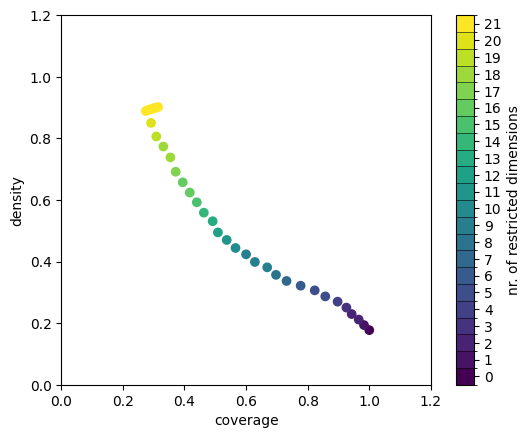

In [91]:
boxes_accept.show_tradeoff()
plt.show()